In [1]:
# # ML Trader
import numpy as np
import pandas as pd

import collections

from tqdm import tqdm

from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = {}

year = 2021
data['input_rows'] = 10000

source_file_path = f'..\\data\\yearly_tick_data\\{year}.csv'

if data['input_rows'] is None:
    df = pd.read_csv(source_file_path)
else:
    df = pd.read_csv(source_file_path, nrows=data['input_rows'])

In [3]:
def get_prices(data):
    data['tick'] = (data['ask'] + data['bid'])/2    
    df['tick'][i] = data['tick']
    return(data)

In [4]:
def before_sma(data):   
    data['sma_list'].append(data['tick'])    
    return(data)

def after_sma(data):     
    data['sma_list'].popleft()
    data['sma_list'].append(data['tick'])
    data['sema'] = list(pd.DataFrame(list(data['sma_list'])).ewm(span=data['sema_len']).mean()[0])[-1]
    return(data)

def before_lma(data):   
    data['lma_list'].append(data['tick'])    
    return(data)

def after_lma(data):     
    data['lma_list'].popleft()
    data['lma_list'].append(data['tick'])
    data['lema'] = list(pd.DataFrame(list(data['lma_list'])).ewm(span=data['lema_len']).mean()[0])[-1]
    return(data)

In [5]:
def print_report(data):
    display.clear_output(wait = True)
    print('--------------------------')
    print(f'sma_list len  = {len(data["sma_list"])}')
    print(f'lma_list len  = {len(data["lma_list"])}')
    print('--------------------------')
    return()

In [6]:
data['sma_list'] = collections.deque()
data['lma_list'] = collections.deque()
data['sema_len'] = 10
data['lema_len'] = 20

df['tick'] = np.float()
df['sema'] = np.float()
df['lema'] = np.float()

In [7]:
for i in tqdm(range(0, len(df))):
    data['ask'] = df['Ask'][i]
    data['bid'] = df['Bid'][i]
    data = get_prices(data)
    
    #print_report(data)
    
    if len(data['sma_list']) < data['sema_len']:
        data =  before_sma(data)
        continue
        
    if len(data['sma_list']) == data['sema_len']:
        data = after_sma(data)        
    
    if len(data['lma_list']) < data['lema_len']:
        data = before_lma(data)        
        continue
        
    if len(data['lma_list']) == data['lema_len']:
        data = after_lma(data)        
        
    
    df['sema'][i] = data['sema']
    df['lema'][i] = data['lema']
    
    
df = df[df['sema'] != 0]
df = df[df['lema'] != 0]

100%|█████████████████████████████████████| 10000/10000 [00:25<00:00, 385.22it/s]


In [8]:
df.head()

,DateTime,Bid,Ask,Volume,tick,sema,lema
30,20210103 22:01:20.623,1.22395,1.22406,1,1.224005,1.223954,1.223957
31,20210103 22:01:23.137,1.22390,1.22396,6,1.223930,1.223947,1.223953
32,20210103 22:01:23.238,1.22395,1.22397,1,1.223960,1.223951,1.223953
33,20210103 22:01:23.289,1.22395,1.22406,1,1.224005,1.223961,1.223958
34,20210103 22:01:42.162,1.22399,1.22407,1,1.224030,1.223977,1.223968


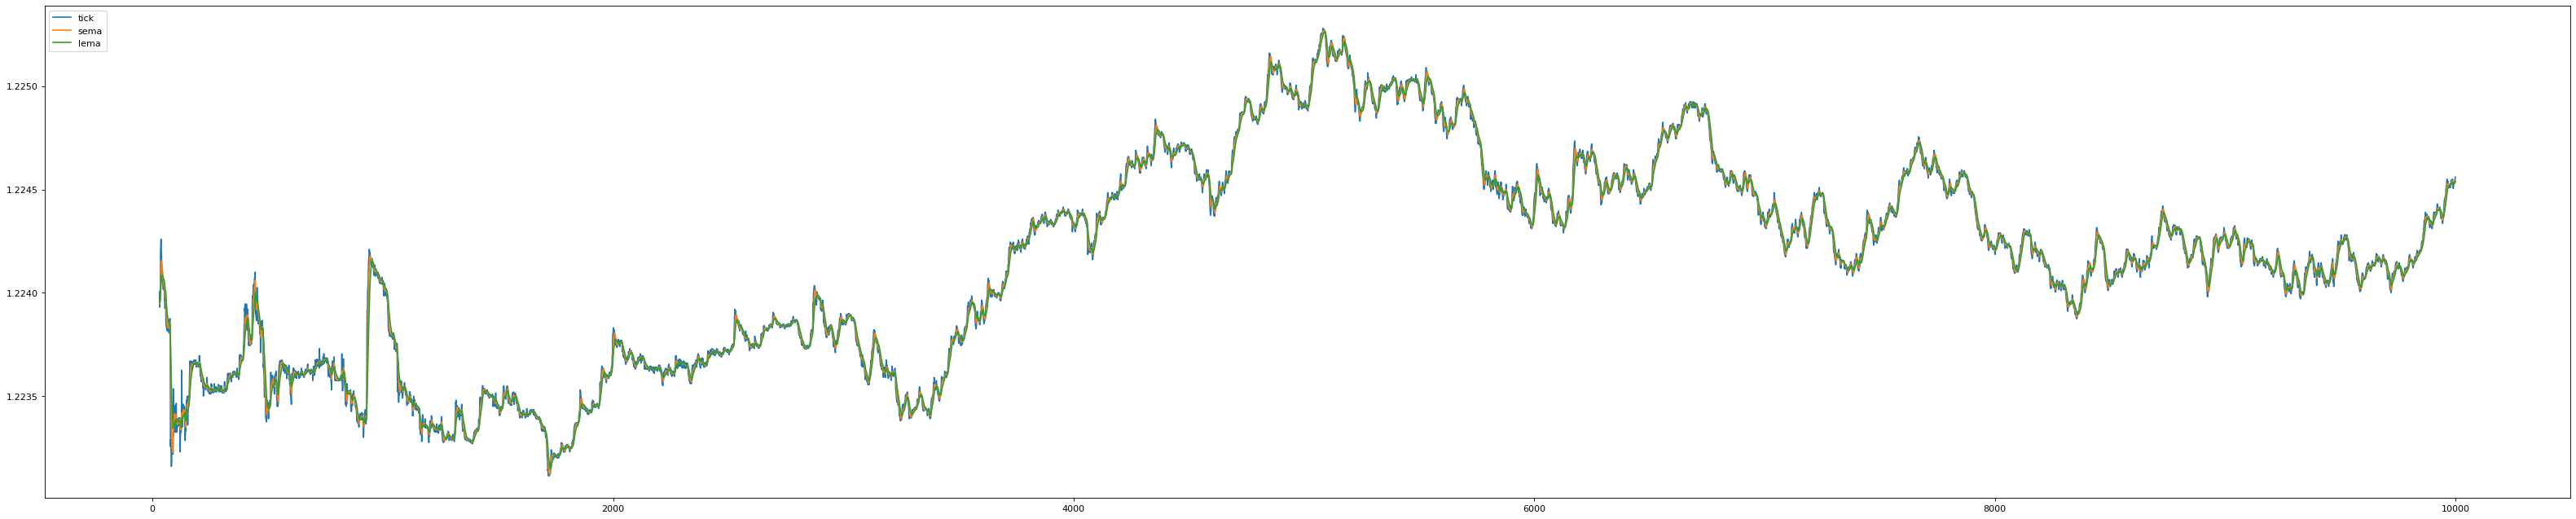

In [9]:
figure(num=None, figsize=(50, 10), dpi=80, facecolor='w', edgecolor='k')

df['tick'].plot(label = 'tick')
df['sema'].plot(label = 'sema')
df['lema'].plot(label = 'lema')
plt.legend(loc="upper left")

In [10]:
df.head()

,DateTime,Bid,Ask,Volume,tick,sema,lema
30,20210103 22:01:20.623,1.22395,1.22406,1,1.224005,1.223954,1.223957
31,20210103 22:01:23.137,1.22390,1.22396,6,1.223930,1.223947,1.223953
32,20210103 22:01:23.238,1.22395,1.22397,1,1.223960,1.223951,1.223953
33,20210103 22:01:23.289,1.22395,1.22406,1,1.224005,1.223961,1.223958
34,20210103 22:01:42.162,1.22399,1.22407,1,1.224030,1.223977,1.223968
